# Eval checkpoints

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, os.path.abspath('../../../../'))
#print(sys.path)

import glob
import json
import re
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
import time
import copy
import pandas as pd
from pandas import DataFrame
from examples.few_shot.scripts.display_results import get_checkpoint_step_form_modelname, load_results
from examples.few_shot.tasks_organization import get_task_display_groups, get_tasks_to_groups_mapping, get_groups_to_groups_mapping, invert_dict

task_display_groups = get_task_display_groups()
task_display_groups["all_no_blimp"] = [x for x in task_display_groups["all"] if not x.startswith("blimp")]
task_to_groups = get_tasks_to_groups_mapping(task_display_groups)
groups_to_groups = get_groups_to_groups_mapping(task_display_groups)

# update task to groups with groups to groups -- to show all for groups, etc


Read the raw results file:

In [2]:
# This is the path to the raw results file generated with the script

# python examples/few_shot/scripts/collect_results.py -i /checkpoint/tbmihaylov/few_shot/2021-06-14-ppl-eval -o _results/2021-06-14-ppl-eval-results.tsv -r 
#results_json = "/private/home/tbmihaylov/fairseq-xlmg/_results/2021-06-14-ppl-eval-results.tsv.raw.jsonl"

# python examples/few_shot/scripts/collect_results.py -i /checkpoint/tbmihaylov/few_shot/2021-06-30-ppl-eval-moe -o _results/2021-06-30-ppl-eval-moe.tsv -r
#results_json = "/private/home/tbmihaylov/fairseq-xlmg/_results/2021-06-30-ppl-eval-moe.tsv.raw.jsonl"

#python examples/few_shot/scripts/collect_results.py -i /checkpoint/tbmihaylov/few_shot/2021-06-14-ppl-eval /checkpoint/tbmihaylov/few_shot/2021-06-30-ppl-eval-moe  -o _results/2021-07-06-ppl-eval-results-dense-and-moe.tsv -r 
#results_json = "/private/home/tbmihaylov/fairseq-xlmg/_results/2021-07-06-ppl-eval-results-dense-and-moe.tsv.raw.jsonl"

#python examples/few_shot/scripts/collect_results.py -i /checkpoint/tbmihaylov/few_shot/2021-07-23-ppl-eval-checkpoints -o _results/2021-07-23-ppl-eval-checkpoints.tsv -r 
results_json = "/private/home/tbmihaylov/fairseq-xlmg/_results/2021-07-23-ppl-eval-checkpoints.tsv.raw.jsonl"

#python examples/few_shot/scripts/collect_results.py -i /checkpoint/tbmihaylov/few_shot/2021-07-calibration -o _results/2021-07-calibration.tsv -r 
#results_json = "/private/home/tbmihaylov/fairseq-xlmg/_results/2021-07-calibration.tsv.raw.jsonl"

#results_json = "/checkpoint/tbmihaylov/few_shot/multilingual_xnli_1.3B_gpt3_setting_checkpoints/results.tsv.raw.jsonl"

# python examples/few_shot/scripts/collect_results.py -i /checkpoint/tbmihaylov/few_shot/2021-09-28-ppl-eval -o /checkpoint/tbmihaylov/few_shot/2021-09-28-ppl-eval/results.tsv -v preferred_metrics_mean -r
#results_json = "/checkpoint/tbmihaylov/few_shot/2021-09-28-ppl-eval/results.tsv.raw.jsonl"

# python examples/few_shot/scripts/collect_results.py -i /checkpoint/victorialin/few_shot/dense_7.5B_lang30_new_cc100_xl_unigram_en_tasks/ /checkpoint/victorialin/few_shot/dense_7.5B_lang30_new_cc100_xl_unigram_mutli_tasks_v1 /checkpoint/victorialin/few_shot/moe_200B_lang30_new_cc100_xl_unigram_en_tasks/ /checkpoint/victorialin/few_shot/moe_200B_lang30_new_cc100_xl_unigram_mutli_tasks_v1/ results.tsv -v preferred_metrics_mean -r
results_json = ["/private/home/tbmihaylov/fairseq-xlmg/_results/2021-10-06-results/results.tsv.raw.jsonl",
                "/checkpoint/tbmihaylov/few_shot/2021-09-28-ppl-eval/results.tsv.raw.jsonl"]
    
results_json = "/private/home/tbmihaylov/fairseq-xlmg/_results/2021-07-23-ppl-eval-checkpoints.tsv.raw.jsonl"

In [3]:
if not results_json.endswith(".tsv.raw.jsonl"):
    raise ValueError("Your file must end with tsv.raw.jsonl")
    


In [4]:
plot_by_steps = True
language = "any"
x_min, x_max = 20000, 1000000
expand_task_groups = True

def filter_item(item):
    skip = False

    if language!= "any" and item["language"] != language:
        return True

    if "checkpoint_steps" in item:
        if x_min is not None and item["checkpoint_steps"] < x_min:
            return True
        if x_max is not None and item["checkpoint_steps"] > x_max:
            return True
    
    return skip

def postprocess(item):
    if item["model_name"] == "moe_15B" and plot_by_steps:
        item["model_name"] = "moe_15B__step00572000"
    pass
        
results_loaded, expanded_results, current_tasks_to_groups = load_results(results_json, 
                 task_to_groups=task_to_groups, 
                 filter_item=None,
                 postprocess=None)

model_name_to_checkpoints = {item["model_name"]: item["checkpoint_steps"] for item in results_loaded}
print(f"{len(results_loaded)} items + {len(expanded_results)} expanded items")

results = results_loaded + expanded_results

# pring result grouping
current_groups = invert_dict(current_tasks_to_groups)
for k,v in current_groups.items():
    print_v = v[:10] + (['...'] if len(v)>10 else [])
    print(f"-{k} ({len(v)}): {', '.join(print_v)}")
print()


3229 items + 9733 expanded items
-LM (1): hellaswag
-all (79): arcchallenge, arceasy, blimp__adjunct_island, blimp__anaphor_gender_agreement, blimp__anaphor_number_agreement, blimp__animate_subject_passive, blimp__animate_subject_trans, blimp__causative, blimp__complex_np_island, blimp__coordinate_structure_constraint_complex_left_branch, ...
-all_no_blimp (12): arcchallenge, arceasy, boolq, cb, copa, hellaswag, openbookqa, piqa, rte, wic, ...
-blimp__all (67): blimp__adjunct_island, blimp__anaphor_gender_agreement, blimp__anaphor_number_agreement, blimp__animate_subject_passive, blimp__animate_subject_trans, blimp__causative, blimp__complex_np_island, blimp__coordinate_structure_constraint_complex_left_branch, blimp__coordinate_structure_constraint_object_extraction, blimp__determiner_noun_agreement_1, ...
-blimp__anaphor_agreement (2): blimp__anaphor_gender_agreement, blimp__anaphor_number_agreement
-blimp__argument_structure (9): blimp__animate_subject_passive, blimp__animate_subjec

In [5]:
print(model_name_to_checkpoints)

{'1.3B_gpt3_setting__step00020000': 20000, '1.3B_gpt3_setting__step00050000': 50000, '1.3B_gpt3_setting__step00100000': 100000, '1.3B_gpt3_setting__step00150000': 150000, '1.3B_gpt3_setting__step00200000': 200000, '1.3B_gpt3_setting__step00250000': 250000, '1.3B_gpt3_setting__step00001000': 1000, '1.3B_gpt3_setting__step00002000': 2000, '1.3B_gpt3_setting__step00003000': 3000, '1.3B_gpt3_setting__step00004000': 4000, '1.3B_gpt3_setting__step00005000': 5000, '1.3B_gpt3_setting__step00006000': 6000, '1.3B_gpt3_setting__step00007000': 7000, '1.3B_gpt3_setting__step00008000': 8000, '1.3B_gpt3_setting__step00009000': 9000, '1.3B_gpt3_setting__step00010000': 10000, '1.3B_gpt3_setting__step00011000': 11000, '1.3B_gpt3_setting__step00012000': 12000, '1.3B_gpt3_setting__step00013000': 13000, '1.3B_gpt3_setting__step00014000': 14000}


In [6]:
df = DataFrame.from_records(results)
print({x: 0.0 for x in set(df["model_name"])})
# drop some overgenerated columns
columns_to_drop = [x for x in list(df.columns) if x.startswith("ppl_candidates_full_prompt__")]
df.drop(columns=columns_to_drop, inplace=True)
list(df.columns)

{'1.3B_gpt3_setting__step00250000': 0.0, '1.3B_gpt3_setting__step00007000': 0.0, '1.3B_gpt3_setting__step00005000': 0.0, '1.3B_gpt3_setting__step00050000': 0.0, '1.3B_gpt3_setting__step00006000': 0.0, '1.3B_gpt3_setting__step00003000': 0.0, '1.3B_gpt3_setting__step00020000': 0.0, '1.3B_gpt3_setting__step00008000': 0.0, '1.3B_gpt3_setting__step00002000': 0.0, '1.3B_gpt3_setting__step00001000': 0.0, '1.3B_gpt3_setting__step00010000': 0.0, '1.3B_gpt3_setting__step00150000': 0.0, '1.3B_gpt3_setting__step00009000': 0.0, '1.3B_gpt3_setting__step00013000': 0.0, '1.3B_gpt3_setting__step00200000': 0.0, '1.3B_gpt3_setting__step00100000': 0.0, '1.3B_gpt3_setting__step00014000': 0.0, '1.3B_gpt3_setting__step00012000': 0.0, '1.3B_gpt3_setting__step00011000': 0.0, '1.3B_gpt3_setting__step00004000': 0.0}


['model_name',
 'task',
 'language',
 'template',
 'nb_few_shot_samples',
 'calibration_options',
 'calibrator_name',
 'ppl_common_prefix::scores',
 'ppl_common_prefix::mean',
 'ppl_common_prefix::std',
 'ppl_common_prefix::mean_confidence_interval',
 'ppl_selected_candidate::scores',
 'ppl_selected_candidate::mean',
 'ppl_selected_candidate::std',
 'ppl_selected_candidate::mean_confidence_interval',
 'ppl_full_selected_candidate::scores',
 'ppl_full_selected_candidate::mean',
 'ppl_full_selected_candidate::std',
 'ppl_full_selected_candidate::mean_confidence_interval',
 'ppl_candidates_full_prompt::scores',
 'ppl_candidates_full_prompt::mean',
 'ppl_candidates_full_prompt::std',
 'ppl_candidates_full_prompt::mean_confidence_interval',
 'ppl_candidates::scores',
 'ppl_candidates::mean',
 'ppl_candidates::std',
 'ppl_candidates::mean_confidence_interval',
 'accuracy::scores',
 'accuracy::mean',
 'accuracy::std',
 'accuracy::mean_confidence_interval',
 'ppl_answer_correct_gold::scores',


The results has the followinf columns:

In [7]:
selected_df = df

main_target_metric = 'accuracy::mean'
metrics_cols = sorted([x + "::mean" for x in list(set(selected_df["_metric"]))])

print(f"metrics_cols:{metrics_cols}")


value_columns = metrics_cols


metric_pt = pd.pivot_table(selected_df, values=value_columns, index=['task',"language", 'template', 'nb_few_shot_samples', "_metric"],
                    columns=['model_name', 
                             #'calib'
                            ], aggfunc=np.mean)

out_file = results_json+"_ppl_selected_metrics.tsv"
metric_pt.to_csv(out_file, sep="\t")
print(f"exported to {out_file}")

metric_pt

metrics_cols:['accuracy::mean']
exported to /private/home/tbmihaylov/fairseq-xlmg/_results/2021-07-23-ppl-eval-checkpoints.tsv.raw.jsonl_ppl_selected_metrics.tsv


accuracy::mean  \
model_name                                                  1.3B_gpt3_setting__step00001000   
task       language template   nb_few_shot_samples _metric                                    
LM         en       *          0                   accuracy                       25.333599   
                               4                   accuracy                       24.785899   
                               32                  accuracy                             NaN   
all        en       *          0                   accuracy                       60.751604   
                               4                   accuracy                       68.239924   
...                                                                                     ...   
winogrande en       winogrande 4                   accuracy                       50.244672   
                               32                  accuracy                             NaN   
wsc        en       wsc        0                   accuracy                       38.461538   
                               4                   accuracy                       50.961538   
                               32                  accuracy                             NaN   

                                                                                             \
model_name                                                  1.3B_gpt3_setting__step00002000   
task       language template   nb_few_shot_samples _metric                                    
LM         en       *          0                   accuracy                       26.687911   
                               4                   accuracy                       26.403107   
                               32                  accuracy                             NaN   
all        en       *          0                   accuracy                       69.225652   
                               4                   accuracy                       78.735196   
...                                                                                     ...   
winogrande en       winogrande 4                   accuracy                       51.554854   
                               32                  accuracy                             NaN   
wsc        en       wsc        0                   accuracy                       54.807692   
                               4                   accuracy                       41.923077   
                               32                  accuracy                             NaN   

                                                                                             \
model_name                                                  1.3B_gpt3_setting__step00003000   
task       language template   nb_few_shot_samples _metric                                    
LM         en       *          0                   accuracy                       28.191595   
                               4                   accuracy                       28.191595   
                               32                  accuracy                             NaN   
all        en       *          0                   accuracy                       72.111359   
                               4                   accuracy                       80.375991   
...                                                                                     ...   
winogrande en       winogrande 4                   accuracy                       50.891871   
                               32                  accuracy                             NaN   
wsc        en       wsc        0                   accuracy                       50.000000   
                               4                   accuracy                       40.961538   
                               32                  accuracy                             NaN   

                                                                                    

In [8]:

idx_to_metrics_by_model = {}

metric_cols_all = []
ppl_cols_all = []

for idx, row in metric_pt.iterrows():
    #print(idx, row.items())
    curr_task_name = idx[0]
    curr_shots=idx[3]
    #print(curr_task_name)
    #break
    
    
    cols_with_vals_by_model = {}
    
    for [col, model], val in row.items():
        if not col.endswith("::mean"):
            # Use only result columns
            continue
        if col not in cols_with_vals_by_model:
            cols_with_vals_by_model[col] = []
        cols_with_vals_by_model[col].append((model, val))
    
    #print(f"cols_with_vals_by_model:{cols_with_vals_by_model}")
    #break
    # sort model names and values
    for col in cols_with_vals_by_model.keys():
        cols_with_vals_by_model[col] = sorted(cols_with_vals_by_model[col], key=lambda x: x[0])
        
    idx_to_metrics_by_model[idx] = cols_with_vals_by_model

# Display by steps
Below, we plot results for multiple checkpoints.

In [9]:
#Example for idx_to_metrics_by_model:
debug_custom=False
if debug_custom:
    idx_to_metrics_by_model = {('knowledge__common_sense',  # task_name or group_name
      'en',
      '*',
      0,
      'accuracy'): {'accuracy::mean': [('1.3B_gpt3_setting__step00020000',
        42.86994622585142),
       ('1.3B_gpt3_setting__step00050000', 49.581756622186816),
       ('1.3B_gpt3_setting__step00100000', 53.316072495518824),
       ('1.3B_gpt3_setting__step00150000', 55.67616012746465),
       ('1.3B_gpt3_setting__step00200000', 57.040430193188605),
       ('1.3B_gpt3_setting__step00250000',
        58.1557458673571)], },
    ('knowledge',  # task_name or group_name
      'en',
      '*',
      0,
      'accuracy'): {'accuracy::mean': [('1.3B_gpt3_setting__step00020000',
        52.86994622585142),
       ('1.3B_gpt3_setting__step00050000', 59.581756622186816),
       ('1.3B_gpt3_setting__step00100000', 53.316072495518824),
       ('1.3B_gpt3_setting__step00150000', 55.67616012746465),
       ('1.3B_gpt3_setting__step00200000', 57.040430193188605),
       ('1.3B_gpt3_setting__step00250000',
        68.1557458673571)], }
    }


    #If you want to plot multiple lines on the same plot, define task_to_group or group_to_group mappings
    task_to_groups = {
    "knowledge__common_sense": ["knowledge"]
    }


In [10]:
#idx_to_metrics_by_model

In [11]:
task_settings_with_metrics = [x[0] for x in idx_to_metrics_by_model.keys()]


Filtering only nshots==0! Set nshots_eq to None to remove the filter!
fig:('LM', 'en', '*', 0, 'accuracy')
WARNING - No handles with labels found to put in legend.


<ipython-input-15-e2f6f2f5f462>:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_main.set_xticklabels(ax_main.get_xticks(), rotation = 45)


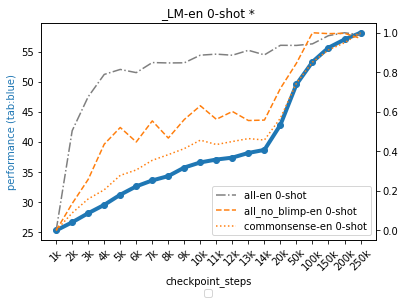

fig:('all', 'en', '*', 0, 'accuracy')
WARNING - No handles with labels found to put in legend.
WARNING - No handles with labels found to put in legend.


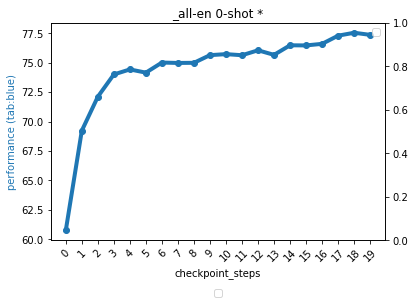

fig:('all_no_blimp', 'en', '*', 0, 'accuracy')
WARNING - No handles with labels found to put in legend.


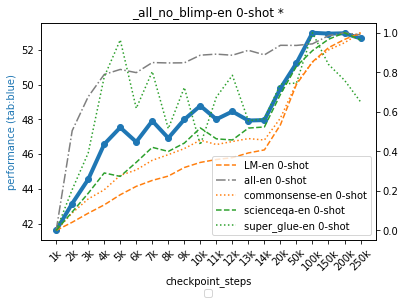

fig:('arcchallenge', 'en', 'arc_old', 0, 'accuracy')


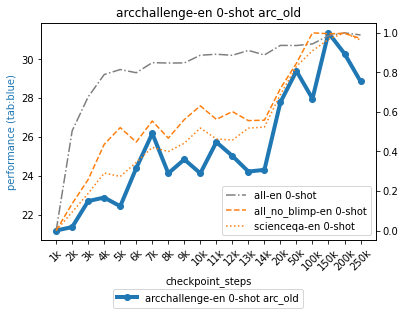

fig:('arceasy', 'en', 'arc_old', 0, 'accuracy')


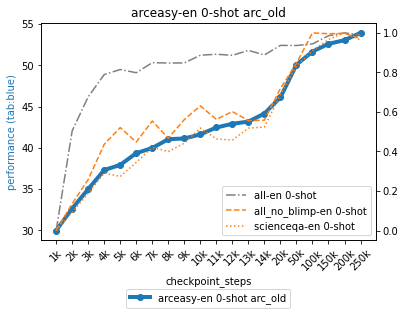

fig:('blimp__adjunct_island', 'en', 'blimp', 0, 'accuracy')


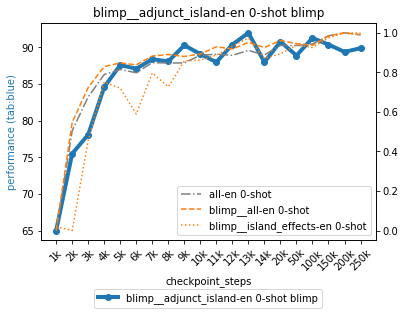

fig:('blimp__all', 'en', '*', 0, 'accuracy')
WARNING - No handles with labels found to put in legend.


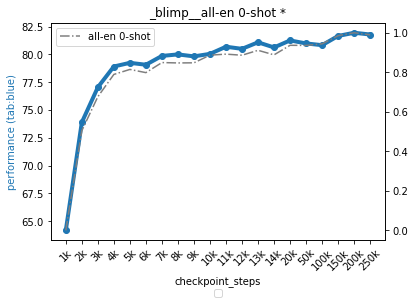

fig:('blimp__anaphor_agreement', 'en', '*', 0, 'accuracy')
WARNING - No handles with labels found to put in legend.


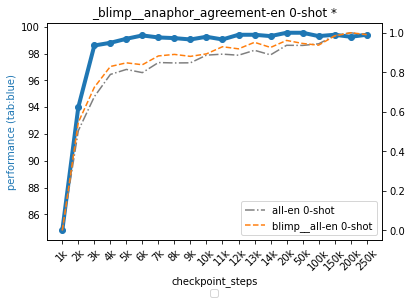

fig:('blimp__anaphor_gender_agreement', 'en', 'blimp', 0, 'accuracy')


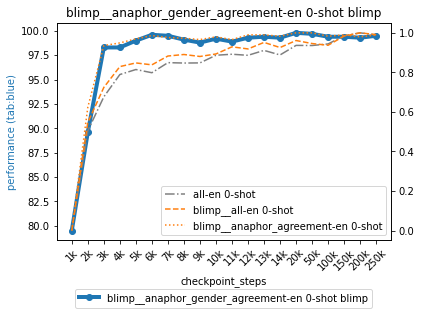

fig:('blimp__anaphor_number_agreement', 'en', 'blimp', 0, 'accuracy')


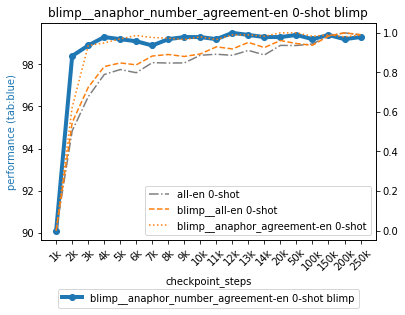

fig:('blimp__animate_subject_passive', 'en', 'blimp', 0, 'accuracy')


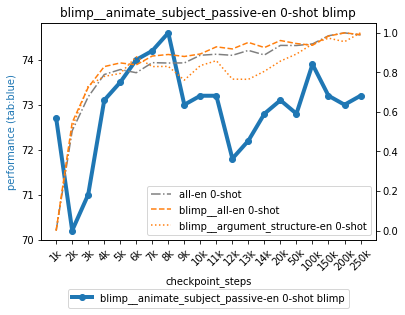

fig:('blimp__animate_subject_trans', 'en', 'blimp', 0, 'accuracy')


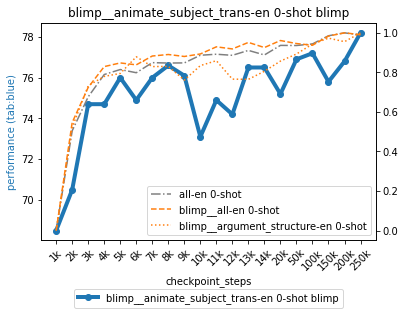

fig:('blimp__argument_structure', 'en', '*', 0, 'accuracy')
WARNING - No handles with labels found to put in legend.


In [ ]:
def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

max_plotted = 0
# task_to_groups
# task_display_groups
def normalize(vals, lower=0.0, upper=1.0):
    min_val = min(vals)
    max_val = max(vals)
    return [lower + (x - min_val) * (upper - lower)/(0.0001 + max_val - min_val) for x in vals]
    
def get_plot_fields(v, col_info, related_vals=False):
    metric_key = col_info["key"]
    vals_func = col_info["vals_func"]
    if related_vals:
        rel_vals_func = col_info.get("related_vals_func", None)
        if rel_vals_func is not None:
            vals_func = rel_vals_func
        
        rel_lbl = False
        
    vals = vals_func(v[metric_key])
    lbl = col_info["lbl"] if not related_vals else col_info.get("rel_lbl", col_info["lbl"])
    
    return lbl, vals

# Line styles
main_style = {"color":"tab:blue", "linewidth":4, "marker":'o'}
special_styles = {"all": {"linestyle":"-.", "color":"tab:gray"}}
related_styles = [{"color":cl, "linestyle":lst} for cl in ["tab:orange", "tab:green", "tab:red", "tab:purple", 
                                                           "tab:brown", "tab:pink", "tab:olive", "tab:cyan"]
                                                for lst in ["dashed", "dotted"] ]

# ('arceasy', 'en', 'arc_old', 0, 'accuracy'), {'accuracy::mean': [('1.3B_gpt3_setting__step00020000', 46.11283873833852), ('1.3B_gpt3_setting__step00050000', 50.06663705019991), ('1.3B_gpt3_setting__step00100000', 51.66592625499778), ('1.3B_gpt3_setting__step00150000', 52.59884495779654)
x_columns = [{'lbl': "checkpoint_steps", "key": 'accuracy::mean', "vals_func": lambda vals: [str(int(get_checkpoint_step_form_modelname(x)/1000))+'k' for x, y in vals]}]
y_columns = [
    {'lbl': "performance", "key": 'accuracy::mean', "vals_func": lambda vals: [y for x, y in vals],
                                  'rel_lbl': "performance (normalized)",  "related_vals_func": lambda vals: normalize([y for x, y in vals]),
    "plot_related": True},
             #{'lbl': "ppl-contrast - normalized", "key": 'contrast-ppl-ratio--ppl_full_correct_gold-ppl_full_incorrect_gold::mean', "vals_func": lambda vals: normalize([y for x, y in vals])}
 #            {'lbl': "performance", "key": 'accuracy::mean', "vals_func": lambda vals: [y for x, y in vals], "plot_related": False},
            ]


plotted_cnt =  0 

nshots_eq = 0
if nshots_eq is not None:
    print(f"Filtering only nshots=={nshots_eq}! Set nshots_eq to None to remove the filter!")
    
for exp_setting, exp_results in idx_to_metrics_by_model.items():
    task=exp_setting[0]
    if nshots_eq is not None and exp_setting[3] != nshots_eq:
        continue
    
    print(f"fig:{exp_setting}")
    
    group_prefix = ""
    if task in groups_to_groups:
        group_prefix = "_"
    title = "{group_prefix}{task}-{lang} {shots}-shot {template}".format(task=task, lang=exp_setting[1], template=exp_setting[2], shots=exp_setting[3], group_prefix=group_prefix)
    main_results = exp_results  # these are the results to plot as main
    #print(main_results)
    
    # we also plate the grouped results where the current seting participates
    related_results = []
    curr_task_groups = list(set(task_to_groups.get(task, []) + groups_to_groups.get(task, [])))
    for ctg in curr_task_groups:
        rel_result_key = (ctg, exp_setting[1], "*", exp_setting[3], exp_setting[4])
        if rel_result_key in idx_to_metrics_by_model:
            related_results.append((rel_result_key, idx_to_metrics_by_model[rel_result_key]))
    related_results.sort(key = lambda x: x[0][0])
    
    for x_col in x_columns:
        for y_col in y_columns:
            plot_rel_on_sep_ax = "related_vals_func" in y_col
            plt.rcParams['axes.facecolor']='white'
            fig, ax_main = plt.subplots()
            rect = fig.patch
            rect.set_facecolor("white")
            
            ax_rel = ax_main.twinx() if plot_rel_on_sep_ax else ax_main
            
            # main results
            x_lbl, x_vals, y_lbl, y_vals = get_plot_fields(main_results, x_col) + get_plot_fields(main_results, y_col)
            ax_main.plot(x_vals, y_vals, label=title, **main_style)
            ax_main.set_xticklabels(ax_main.get_xticks(), rotation = 45)
            ax_main.set_ylabel(f"{y_lbl} ({main_style['color']})", color=main_style['color'])
            ax_main.set_xlabel(x_lbl)
            
            
            
            if y_col.get("plot_related", False):
                rel_style_id = 0
                # related results (groups)
                for rel_setting, rel_result in related_results:
                    rel_task_name = rel_setting[0]
                    rel_title = "{task}-{lang} {shots}-shot".format(task=rel_task_name, lang=rel_setting[1], shots=rel_setting[3])
                    _, rel_x_vals, rel_y_lbl, rel_y_vals = get_plot_fields(rel_result, x_col, related_vals=True) + get_plot_fields(rel_result, y_col, related_vals=True)

                    # style 
                    rel_style = special_styles.get(rel_task_name, None)
                    if rel_style is None:
                        rel_style = related_styles[rel_style_id]
                        rel_style_id += 1

                    ax_rel.plot(rel_x_vals, rel_y_vals, label=rel_title, **rel_style)
                
#                 if plot_rel_on_sep_ax:
#                     ax_rel.set_ylabel(f"{rel_y_lbl}")
            
            if plot_rel_on_sep_ax:
                ax_rel.legend()
                ax_main.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))
            else:
                ax_main.legend()
                
            plt.title(title)
            plt.show()
    
    plotted_cnt += 1
    if max_plotted > 0 and plotted_cnt> max_plotted:
        break


